２ノードのグラフィカルモデル でサンプリングEMアルゴリズムを実装する。

In [732]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy
from sklearn.linear_model import LinearRegression,Ridge,Lasso
import math
from sklearn import preprocessing

関数（２ノード）

In [911]:
#尤度の式
def loglikelihood(df,pa_mu,pa_sigma,child_sigma,weight,bias):
    loglikelihood = 0
    for i in range(len(df)):
        loglikelihood += -2*np.log(2*np.pi)/2 - np.log(pa_sigma)/2 -np.log(child_sigma)/2\
        - (df["pa"][i] - pa_mu)**2/(2*pa_sigma) - (df["child"][i] - weight*df["pa"][i] - bias)**2/(2*child_sigma)
    return loglikelihood    

In [1042]:
#親ノードの条件付き分布の平均と分散を求める式→正しい。（解析的な解と照合）
def conditional_paramators_2_node(weights,df,pa_mu,pa_sigma,child_sigma):
    conditional_mus,conditional_sigmas = [],[]
    for i in range(len(df)):
        sympy.var("x")
        f = -(x - pa_mu)**2/(2*pa_sigma) - (df["child"][i] -weights[0]*x - weights[1])**2/(2*child_sigma)
         #二次項を評価
        condi_sigma_inv = -2*f.expand(x).coeff(x,2)
        #線形項を評価
        condi_mu = f.expand(x).coeff(x,1)/condi_sigma_inv
        condi_sigma = 1/condi_sigma_inv 
    
        conditional_mus.append(condi_mu)
        conditional_sigmas.append(condi_sigma)
    
    return conditional_mus, conditional_sigmas

In [1044]:
#最小二乗法の関数（確認済み）
def LSM(x,y):
    fun = LinearRegression()
    fun.fit(x,y)
    return [fun.coef_.tolist()[0][0],fun.intercept_[0]]#fun.intercept_[0]

def weights_update(df):# 重みの更新を行う関数。
    w = LSM(df["pa"].values.reshape(-1,1),df["child"].values.reshape(-1,1))
    
    return w

In [1045]:
def update_mu_sigma(df):
    pa_mu = df["pa"].mean()
    pa_sigma = df["pa"].var()
    
    return pa_mu,pa_sigma

In [1300]:
def monte_carlo_EM_2_node(weights,df,num_iter):
    df = df
    pa_mu = df["pa"].mean()
    pa_sigma = df["pa"].var()
    child_sigma = 0.25#分散0.25
    
    #記録用
    loglikelihood_list = []
    weights_list = []
    intercept_list = []
    mu_list,sigma_list = [],[]
    for h in range(num_iter):
        condi_mus,condi_sigmas = conditional_paramators_2_node(weights,df,pa_mu,pa_sigma,child_sigma)
        #Eステップ
        #サンプリングした値でdataframeの値を更新。
        for i in range(len(df)):
            df["pa"][i] = np.random.normal(condi_mus[i],math.sqrt(condi_sigmas[i]),1)[0]#np.random.normal の引数は平均と標準偏差
        #Mステップ    
        weights = weights_update(df) #重みを更新
        #pa_mu,pa_sigma = update_mu_sigma(df)#平均と分散を更新  重みのみ更新
        
        loglikelihood_list.append(loglikelihood(df,pa_mu,pa_sigma,child_sigma,weights[0],weights[1]))
        weights_list.append(weights[0])#重みの係数を記録
        intercept_list.append(weights[1])#重みの切片を記録
        mu_list.append(pa_mu)#平均を記録
        sigma_list.append(pa_sigma)#分散を記録
    return  weights_list,intercept_list,mu_list,sigma_list,loglikelihood_list

テストデータを作る。

In [1301]:
pa = np.random.normal(0,1,100)#親ノード　平均０　標準偏差１ P(x)

child = []
for i in range(len(pa)):
    sample = np.random.normal(pa[i]*3 + 2,0.5,1)[0]#標準偏差0.5 分散0.25
    child.append(sample)
    
child = np.array(child)#p(y|x)

data_list = np.array([pa,child]).T
true_test_df1 = pd.DataFrame(data=data_list,columns = ["pa","child"])#真のテストデータ

In [1302]:
test_df = true_test_df1
#test_df["pa"] = np.random.normal(1,2,100)

In [1303]:
weights_list,intercept_list,mu_list,sigma_list,loglikelihood_list =  monte_carlo_EM_2_node([2,1],test_df,400)

Text(0, 0.5, 'likelihood')

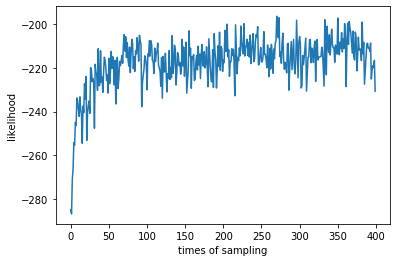

In [1304]:
plt.plot(loglikelihood_list,label="尤度")
plt.xlabel("times of sampling")
plt.ylabel("likelihood")
#尤度

Text(0, 0.5, 'coefficient of weight')

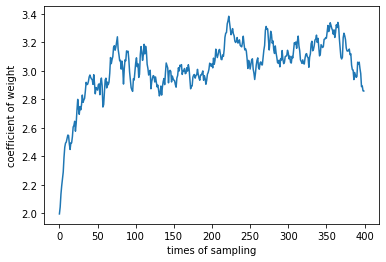

In [1305]:
plt.plot(weights_list)#重みの係数
plt.xlabel("times of sampling")
plt.ylabel("coefficient of weight")

Text(0, 0.5, 'intercept of weight')

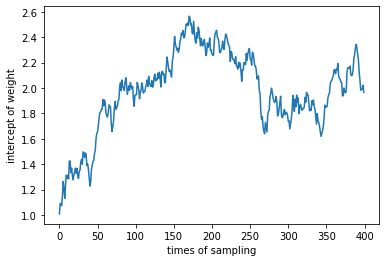

In [1306]:
plt.plot(intercept_list)#重みの切片
plt.xlabel("times of sampling")
plt.ylabel("intercept of weight")

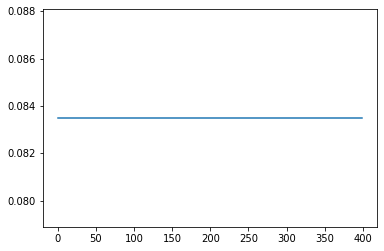

In [1307]:
plt.plot(mu_list)#平均

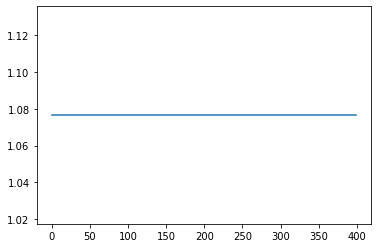

In [1308]:
plt.plot(sigma_list)#分散